# VEP pilot PacBio sequencing 
This example shows how to process PacBio circular consensus sequencing of a PacBio run containing VEP sequences from several different VEPs. 

Here we only analyzed two VEPs and use only a snippet of the full data set of circular consensus sequences so that the example is small and fast.

## Set up for analysis
Import necessary Python modules:

In [1]:
import os
import tempfile
import warnings

import Bio.SeqIO

import pandas as pd

from plotnine import *

import pysam

import alignparse.ccs
import alignparse.minimap2
import alignparse.targets
import alignparse.cs_tag

Suppress warnings that clutter output:

In [2]:
warnings.simplefilter('ignore')

Directory for output:

In [3]:
outdir = './output_files/'
os.makedirs(outdir, exist_ok=True)

## Target amplicon
We have performed sequencing of several VEP amplicons that include VEP sequences along with a PacBio index and several other features.
The amplicons are defined as Genbank files.
First, let's just look at the files:

In [4]:
target_file_names = ['LASV_G1959_WT', 'LASV_G1959_OPT']

targetfiles = [f"input_files/{target_file_name}.gb" for target_file_name in target_file_names]


for targetfile in targetfiles:
    with open(targetfile) as f:
        print(f.read())

LOCUS       LASV_G1959_WT           1730 bp ds-DNA     linear       14-JUN-2019
DEFINITION  .
ACCESSION   
VERSION     
SOURCE      Kate Dusenbury
  ORGANISM  .
COMMENT     PacBio amplicon for LASV G1959 WT sequence
COMMENT     There are single nucleotide tags in the 5' and 3' termini to measure strand exchange.
FEATURES             Location/Qualifiers
     T2A             85..147
                     /label="T2A"
     ZsGreen         15..84
                     /label="ZsGreen"
     termini3        1639..1730
                     /label="3'Termini"
     index           9..14
                     /label="sample_index"
     leader5         1..8
                     /label="5' leader"
     termini5        1..147
                     /label="5'Termini"
     variant_tag5    34..34
                     /variant_1=T
                     /variant_2=C
                     /label="5'VariantTag"
     variant_tag3    1702..1702
                     /variant_1=G
                     /variant_2=A
 

Read the amplicons into a `Targets` object, specifying the features that we require the target to contain:

First, read in the `.yaml` file containing the `feature_parse_specs` for these targets. Here, I specify a T2A `feature_parse_spec` only for the LASV_G1959_WT target to test slightly different `feature_parse_specs` for each target.

In [5]:
VEP_parse_specs_file = 'input_files/VEP_target_feature_parse_specs.yaml'

In [6]:
targets = alignparse.targets.Targets(seqsfile=targetfiles,
                  feature_parse_specs=VEP_parse_specs_file,
                  allow_extra_features=True,
                  allow_clipped_muts_seqs=True)

Plot the targets:

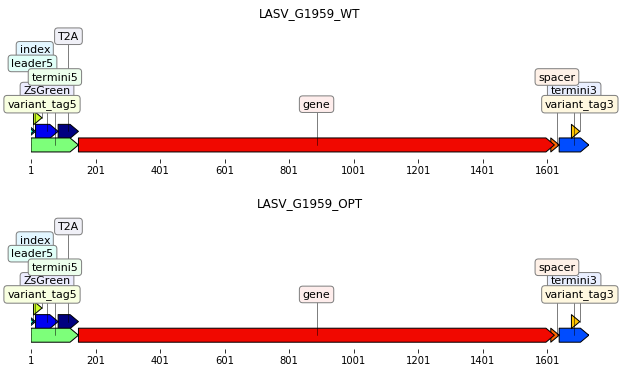

In [7]:
_ = targets.plot(ax_width=10)

We can also look at the featue parsing specifications as a dict or YAML string (here we do it as YAML string):

In [8]:
print(targets.feature_parse_specs('yaml'))

LASV_G1959_WT: &id001
  query_clip5: 10
  query_clip3: 10
  termini5:
    filter:
      clip5: 10
      mutation_nt_count: 1
      mutation_op_count: null
      clip3: 0
    return: []
  T2A:
    filter:
      mutation_nt_count: 5
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return: []
  gene:
    filter:
      mutation_nt_count: 30
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return:
    - mutations
  spacer:
    filter:
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
      clip3: 0
    return: []
  index:
    filter:
      clip5: 3
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
    return:
    - sequence
  termini3:
    filter:
      clip3: 4
      mutation_nt_count: 1
      mutation_op_count: null
      clip5: 0
    return: []
  variant_tag5:
    return:
    - sequence
    filter:
      clip5: 0
      clip3: 0
      mutation_nt_count: 0
      mutation_op_count: 0
  variant_tag3:
    return:
    - seq

## PacBio CCSs
We will align PacBio circular consensus sequences (CCSs) to the target.
First, we want to look at the CCSs.
A FASTQ file with these CCSs along with an associated report file were generated using the PacBio `ccs` program (see [here](https://github.com/PacificBiosciences/ccs) for details on `ccs`) using commands like the following (generates report file and BAM of CCSs):

    ccs --minLength 50 --maxLength 5000 \
        --minPasses 3  --minPredictedAccuracy 0.999 \
        --reportFile vep_pilot_report.txt \
        --polish --numThreads 16 \
        vep_pilot_subreads.bam vep_pilot_ccs.bam
        
The BAM file was then converted to a FASTQ file using [samtools](http://www.htslib.org/) with a flag to retain the number of passes (`np`):

    samtools bam2fq -T np vep_pilot_ccs.bam > vep_pilot_ccs.fastq
    
Here is a data frame with the resulting FASTQ and BAM files:

In [9]:
run_names = ['vep_pilot']
ccs_dir = 'input_files'

pacbio_runs = pd.DataFrame(
            {'name': run_names,
             'report': [f"{ccs_dir}/{name}_report.txt" for name in run_names],
             'fastq': [f"{ccs_dir}/{name}_ccs.fastq" for name in run_names]
             })

pacbio_runs

,name,report,fastq
0,vep_pilot,input_files/vep_pilot_report.txt,input_files/vep_pilot_ccs.fastq


We create a `Summaries` object for these CCSs:

In [10]:
ccs_summaries = alignparse.ccs.Summaries(pacbio_runs)

Plot how many ZMWs yielded CCSs:

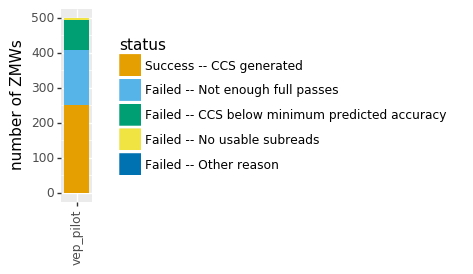

In [11]:
p = ccs_summaries.plot_zmw_stats()
_ = p.draw()

Statistics on the CCSs (length, number of subread passes, accuracy):

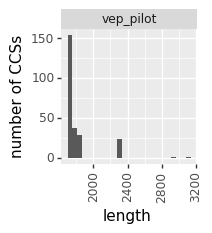

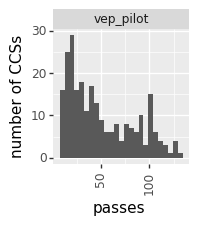

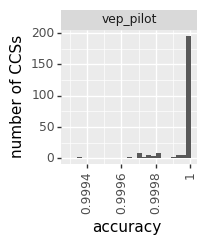

In [12]:
for stat in ['length', 'passes', 'accuracy']:
    if ccs_summaries.has_stat(stat):
        p = ccs_summaries.plot_ccs_stats(stat)
        _ = p.draw()
    else:
        print(f"No information available on CCS {stat}")

## Align CCSs to target
Now we use `minimap2` to align the CCSs to the target.

First, we create a `Mapper` object to run `minimap2`, using the options for codon-level deep mutational scanning:

In [13]:
mapper = alignparse.minimap2.Mapper(alignparse.minimap2.OPTIONS_CODON_DMS)

print(f"Using `minimap2` {mapper.version} with these options:\n" +
      ' '.join(mapper.options))

Using `minimap2` 2.17-r941 with these options:
-A2 -B4 -O12 -E2 --end-bonus=13 --secondary=no --cs


Now use this mapper to do the alignments to a SAM file.
First, add the names of the desired alignment files to our data frame:

In [14]:
pacbio_runs = pacbio_runs.assign(alignments=lambda x: outdir + x['name'] + '_alignments.sam')

pacbio_runs

,name,report,fastq,alignments
0,vep_pilot,input_files/vep_pilot_report.txt,input_files/vep_pilot_ccs.fastq,./output_files/vep_pilot_alignments.sam


Now use the mapper to actually align the FASTQ queries to the target:

In [15]:
for tup in pacbio_runs.itertuples(index=False):
    print(f"Aligning {tup.fastq} to create {tup.alignments}...")
    targets.align(queryfile=tup.fastq,
                  alignmentfile=tup.alignments,
                  mapper=mapper)

Aligning input_files/vep_pilot_ccs.fastq to create ./output_files/vep_pilot_alignments.sam...


These SAM files now contain the alignments along with the [`cs` tag](https://github.com/lh3/minimap2#cs), which contains details on the mutations:

In [16]:
for fname in pacbio_runs['alignments'][:1]:
    with pysam.AlignmentFile(fname) as f:
        a = next(f)
        print(f"First alignment in {fname} has `cs` tag:\n" + a.get_tag('cs'))

First alignment in ./output_files/vep_pilot_alignments.sam has `cs` tag:
:8*nt*nc*nc*ng*nt*nt:19*nc:117


## Parse the alignments
Now we use `Targets.parse_alignments` to parse the SAM files to get the information we specified for return.
This function returns a data frames (`readstats`) on the overall parsing stats, plus dicts keyed by the names of each target in `Targets` giving data frames on the aligned and filtered reads.
We concatenate the data frames for each PacBio run and then look at them together:

In [17]:
readstats = []
aligned = {targetname: [] for targetname in targets.target_names}
filtered = {targetname: [] for targetname in targets.target_names}

for run in pacbio_runs.itertuples():
    
    print(f"Parsing PacBio run {run.name}")
    run_readstats, run_aligned, run_filtered = targets.parse_alignment(run.alignments)
    
    # when concatenating add the run name to keep track of runs for results
    readstats.append(run_readstats
                     .assign(run_name=run.name)
                     )
    for targetname in targets.target_names:
        aligned[targetname].append(run_aligned[targetname]
                                   .assign(run_name=run.name)
                                   )
        filtered[targetname].append(run_filtered[targetname]
                                    .assign(run_name=run.name)
                                    )
        
# now concatenate the data frames for each run
readstats = pd.concat(readstats, ignore_index=True, sort=False)
for targetname in targets.target_names:
    aligned[targetname] = pd.concat(aligned[targetname], ignore_index=True, sort=False)
    filtered[targetname] = pd.concat(filtered[targetname], ignore_index=True, sort=False)

Parsing PacBio run vep_pilot


First lets look at the read stats:

In [18]:
readstats

,category,count,run_name
0,filtered LASV_G1959_WT,97,vep_pilot
1,aligned LASV_G1959_WT,24,vep_pilot
2,filtered LASV_G1959_OPT,110,vep_pilot
3,aligned LASV_G1959_OPT,45,vep_pilot
4,unmapped,2,vep_pilot


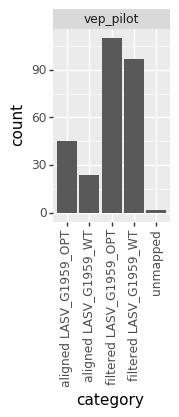

In [19]:
p = (
    ggplot(readstats, aes('category', 'count')) +
    geom_bar(stat='identity') +
    facet_wrap('~ run_name', nrow=1) +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1.5 * len(pacbio_runs), 2.5)
          )
    )
_ = p.draw()

Now look at the information on the filtered reads.
This is a bigger data frame, so we just look at the first few lines for the first target (of which there is only one anyway):

In [20]:
filtered[targets.target_names[0]].head()

,query_name,filter_reason,run_name
0,m54228_190605_190010/4194436/ccs,gene mutation_nt_count,vep_pilot
1,m54228_190605_190010/4194440/ccs,query_clip5,vep_pilot
2,m54228_190605_190010/4194442/ccs,termini5 clip5,vep_pilot
3,m54228_190605_190010/4194449/ccs,query_clip3,vep_pilot
4,m54228_190605_190010/4194452/ccs,query_clip5,vep_pilot


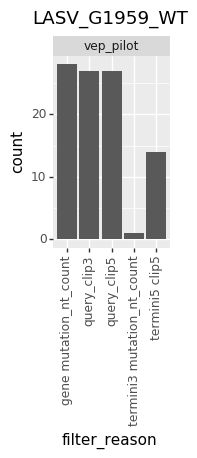

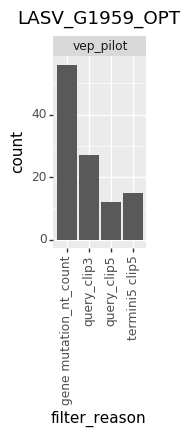

In [21]:
for targetname in targets.target_names:
    target_filtered = filtered[targetname]
    nreasons = target_filtered['filter_reason'].nunique()
    p = (
        ggplot(target_filtered, aes('filter_reason')) +
        geom_bar() +
        facet_wrap('~ run_name', nrow=1) +
        labs(title=targetname) +
        theme(axis_text_x=element_text(angle=90),
              figure_size=(0.3 * nreasons * len(pacbio_runs), 2.5),
              )
        )
    _ = p.draw()

Finally, we can look at the information for the validly aligned (not filtered) reads.
First just look at the first few entries in the data frame for the first target:

In [22]:
show_target0 = targets.target_names[0]
print(show_target0)
aligned[show_target0].head()

LASV_G1959_WT


,query_name,query_clip5,query_clip3,gene_mutations,index_sequence,variant_tag5_sequence,variant_tag3_sequence,run_name
0,m54228_190605_190010/4194411/ccs,0,0,,GTCCGA,T,G,vep_pilot
1,m54228_190605_190010/4194422/ccs,0,0,G312A,GTCCGA,T,G,vep_pilot
2,m54228_190605_190010/4194464/ccs,0,0,,ATTCCA,C,A,vep_pilot
3,m54228_190605_190010/4194470/ccs,0,0,,ATTCCA,T,G,vep_pilot
4,m54228_190605_190010/4194490/ccs,0,0,,ATTCCA,C,A,vep_pilot


In [23]:
show_target1 = targets.target_names[1]
print(show_target1)
aligned[show_target1].head()

LASV_G1959_OPT


,query_name,query_clip5,query_clip3,gene_mutations,index_sequence,variant_tag5_sequence,variant_tag3_sequence,run_name
0,m54228_190605_190010/4194386/ccs,0,0,,GGAGTC,C,A,vep_pilot
1,m54228_190605_190010/4194392/ccs,0,0,,GGAGTC,A,T,vep_pilot
2,m54228_190605_190010/4194393/ccs,0,0,,GGAGTC,C,A,vep_pilot
3,m54228_190605_190010/4194415/ccs,0,0,del587to587,AACAGC,T,G,vep_pilot
4,m54228_190605_190010/4194429/ccs,0,0,,GGAGTC,T,G,vep_pilot
